# 第一題 [Data Preprocessing]

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler

In [2]:
x_train = pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None)
x_test = pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test', header=None)

In [3]:
x_train.head()

,0
0,"39, State-gov, 77516, Bachelors, 13, Never-mar..."
1,"50, Self-emp-not-inc, 83311, Bachelors, 13, Ma..."
2,"38, Private, 215646, HS-grad, 9, Divorced, Han..."
3,"53, Private, 234721, 11th, 7, Married-civ-spou..."
4,"28, Private, 338409, Bachelors, 13, Married-ci..."


In [4]:
x_test.head()

,0
0,|1x3 Cross validator
1,"25, Private, 226802, 11th, 7, Never-married, M..."
2,"38, Private, 89814, HS-grad, 9, Married-civ-sp..."
3,"28, Local-gov, 336951, Assoc-acdm, 12, Married..."
4,"44, Private, 160323, Some-college, 10, Married..."


In [5]:
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'y']
x_train[column_names] = x_train[0].str.split(', ', expand=True)
x_test[column_names] = x_test[0].str.split(', ', expand=True)

x_train = x_train.iloc[:,1:]
x_test = x_test.iloc[1:,1:]

In [6]:
# 把問號變成NaN才能使用dropna
x_train = x_train.replace('?', np.NaN)
x_train = x_train.dropna(axis=0, how='any')

x_test = x_test.replace('?', np.NaN)
x_test = x_test.dropna(axis=0, how='any')

# 調整順序
x_train = x_train[['capital-loss', 'hours-per-week', 'capital-gain', 'educational-num', 'age', 'fnlwgt',
                  'relationship', 'race', 'gender', 'occupation', 'education', 'native-country', 'workclass', 'marital-status', 'y']]

x_test = x_test[['capital-loss', 'hours-per-week', 'capital-gain', 'educational-num', 'age', 'fnlwgt',
                  'relationship', 'race', 'gender', 'occupation', 'education', 'native-country', 'workclass', 'marital-status', 'y']]

y_train = x_train['y']
y_test = x_test['y']

# remove y label
x_train = x_train.drop('y', axis=1)
x_test = x_test.drop('y', axis=1)

In [7]:
x_train.head()

,capital-loss,hours-per-week,capital-gain,educational-num,age,fnlwgt,relationship,race,gender,occupation,education,native-country,workclass,marital-status
0,0,40,2174,13,39,77516,Not-in-family,White,Male,Adm-clerical,Bachelors,United-States,State-gov,Never-married
1,0,13,0,13,50,83311,Husband,White,Male,Exec-managerial,Bachelors,United-States,Self-emp-not-inc,Married-civ-spouse
2,0,40,0,9,38,215646,Not-in-family,White,Male,Handlers-cleaners,HS-grad,United-States,Private,Divorced
3,0,40,0,7,53,234721,Husband,Black,Male,Handlers-cleaners,11th,United-States,Private,Married-civ-spouse
4,0,40,0,13,28,338409,Wife,Black,Female,Prof-specialty,Bachelors,Cuba,Private,Married-civ-spouse


In [8]:
y_train.head()

0    <=50K
1    <=50K
2    <=50K
3    <=50K
4    <=50K
Name: y, dtype: object

In [9]:
# 將'>50K'與'<=50K'轉成1跟0
for i in y_train.index:
    if y_train[i] == '<=50K':
        y_train[i] = 0
    else:
        y_train[i] = 1
    
for i in y_test.index:
    if y_test[i] == '<=50K.':
        y_test[i] = 0
    else:
        y_test[i] = 1

In [10]:
# 把連續變數從object變為number
num_col = ['capital-loss', 'hours-per-week', 'capital-gain', 'educational-num', 'age', 'fnlwgt']

x_train[num_col] = x_train[num_col].apply(pd.to_numeric, errors='coerce')
x_test[num_col] = x_test[num_col].apply(pd.to_numeric, errors='coerce')

In [11]:
# 再區隔numerical和categorical
# numerical
x_train_num = x_train.select_dtypes(include='number')
x_test_num = x_test.select_dtypes(include='number')
# categorical
x_train_cat = x_train.select_dtypes(exclude='number')
x_test_cat = x_test.select_dtypes(exclude='number')

In [12]:
# normalize numerical df 

#scale = StandardScaler()
#x_train_num_normalized = pd.DataFrame(scale.fit_transform(x_train_num), columns=x_train_num.keys())
# x_test_num_normalized = pd.DataFrame(scale.fit_transform(x_test_num), columns=x_test_num.keys())

mu = x_train_num.mean()
std = x_train_num.std(ddof=0)

x_train_num_normalized = (x_train_num - mu) / std
x_test_num_normalized = (x_test_num - mu) / std

In [13]:
x_train_dum = pd.get_dummies(x_train_cat)
x_test_dum = pd.get_dummies(x_test_cat)
# 把特徵值出現不到10次刪掉(針對訓練資料)
x_train_dum = x_train_dum[x_train_dum.columns[x_train_dum.sum()>=10]]

# 測試資料就看訓練資料的columns name
x_test_dum = x_test_dum[x_train_dum.columns]

In [14]:
# 因為等等要merge，所以先統一一下index
x_train_dum.reset_index(drop=True)
x_test_dum.reset_index(drop=True)

# merge numerical and categorical
x_train = x_train_num_normalized.merge(x_train_dum, how='outer', left_index=True, right_index=True)
x_test = x_test_num_normalized.merge(x_test_dum, how='outer', left_index=True, right_index=True)

In [15]:
x_test.head()

,capital-loss,hours-per-week,capital-gain,educational-num,age,fnlwgt,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,...,workclass_Self-emp-not-inc,workclass_State-gov,workclass_Without-pay,marital-status_Divorced,marital-status_Married-AF-spouse,marital-status_Married-civ-spouse,marital-status_Married-spouse-absent,marital-status_Never-married,marital-status_Separated,marital-status_Widowed
1,-0.218586,-0.077734,-0.147445,-1.224066,-1.023104,0.350286,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,-0.218586,0.757005,-0.147445,-0.439738,-0.033340,-0.946320,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,-0.218586,-0.077734,-0.147445,0.736754,-0.794697,1.392858,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,-0.218586,-0.077734,0.890601,-0.047574,0.423474,-0.278945,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6,-0.218586,-0.912474,-0.147445,-1.616231,-0.337883,0.084232,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [16]:
x_train_array = x_train.values
x_test_array = x_test.values
y_train_array = y_train.values
y_test_array = y_test.values
columnname = x_train.columns.values
num_col = x_train_num.columns.values

In [17]:
adult50k = {'x_train': x_train_array,
           'y_train': y_train_array,
           'x_test': x_test_array,
           'y_test': y_test_array,
           'columnname': columnname,
           'num_col': num_col}

### 測試

In [18]:
import pickle
dsfile = 'adult_m50k.pickle'
with open(dsfile, 'rb') as fh1:
    adult50kp = pickle.load(fh1)
    
elems = ['x_train', 'x_test', 'y_train', 'y_test']

for aelem in elems:
    cnomatch = np.sum(adult50kp[aelem] != adult50k[aelem])
    if cnomatch == 0:
        print(aelem, "match!")
    else:
        print(aelem, "%d elements no match!" % cnomatch)

x_train 180972 elements no match!
x_test 90360 elements no match!
y_train match!
y_test match!


### 檢查發現其實只是小數點後十位數以上有些微差異，故實作正確

In [19]:
for aelem in elems:
    # 取到小數點後十位
    cnomatch = np.sum(round(adult50kp[aelem].sum(), 10) != round(adult50k[aelem].sum(), 10))
    if cnomatch == 0:
        print(aelem, "match!")
    else:
        print(aelem, "%d elements no match!" % cnomatch)

x_train match!
x_test match!
y_train match!
y_test match!


# 第二題 [ROC and AUC]

In [20]:
import pickle
from sklearn.linear_model import LogisticRegression
import numpy as np
from numpy import trapz
import matplotlib.pyplot as plt
%matplotlib inline
    
#train prediction model    
c = 0.3
lr2 = LogisticRegression(solver = 'lbfgs', C= c, max_iter = 1000)
lr2.fit(adult50kp['x_train'], adult50kp['y_train'])
#make prediction
ypred = lr2.predict(adult50kp['x_test'])
ypredprob = lr2.predict_proba(adult50kp['x_test'])
#compute accuracy
ncorrect = np.sum(adult50kp['y_test'] == ypred)
accuracy_sk = ncorrect / adult50kp['y_test'].shape[0]
print("Accuracy = %f" % accuracy_sk)    

Accuracy = 0.848406


In [21]:
class roc_auc():
    
    def __init__(self):
        
        pass
    
    def confusion_matrix(self, ground_truth, predict_score, threshold=0.5):
    
        self.tp=self.fp=self.tn=self.fn=0
        self.truth = ground_truth
        self.score = predict_score
        bool_actuals = [a==1 for a in ground_truth]  # True / False

        for i in range(len(ground_truth)):
            if predict_score[i] > threshold:
                if bool_actuals[i] == True:
                    self.tp += 1
                else:
                    self.fp += 1
            else:
                if bool_actuals[i] == False:
                    self.tn += 1
                else:
                    self.fn += 1
        
        return self.tp, self.fp, self.tn, self.fn

    def acc(self):
   
        return (self.tp+self.tn) / (self.tp+self.fp+self.tn+self.fn)

    def fpr(self):
    
        return self.fp / (self.fp+self.tn) if (self.fp+self.tn)!=0 else 0

    def tpr(self):
        
        return self.tp / (self.tp+self.fn) if (self.tp+self.fn)!=0 else 0
    
    def different_threshold(self):
        
        low = min(self.score)
        high = max(self.score)
        step = (abs(low) + abs(high)) / 1000  # 1000 steps
        threshold = np.arange(low-step, high+step, step)
        
        fpr_list = []
        tpr_list = []
        
        for t in threshold:
            self.confusion_matrix(self.truth, self.score, t)
            fpr_list.append(self.fpr())
            tpr_list.append(self.tpr())
            
        self.fprlist = fpr_list
        self.tprlist = tpr_list
            
        return fpr_list, tpr_list

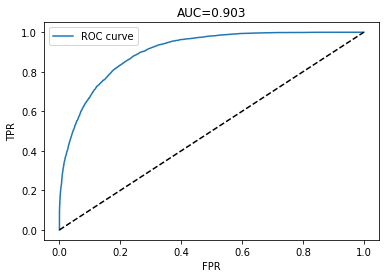

In [22]:
ans = roc_auc()
ans.confusion_matrix(adult50kp['y_test'], ypredprob[:,1])

# check
# print(ans.acc())
# print(ans.different_threshold())

fpr_list = ans.different_threshold()[0]
tpr_list = ans.different_threshold()[1]
auc = np.trapz(tpr_list[::-1],fpr_list[::-1])

# Generate plot
plt.title('AUC={}'.format(round(auc,3)))
plt.plot(fpr_list, tpr_list, label = 'ROC curve')
plt.plot([0,1], [0,1], 'k--')
plt.legend()
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

### 成功繪製出 ROC curve 與計算出 AUC = 0.903

# 第三題 [Logistic Regression with L2 Regularization]

### Q3.1

![image](https://raw.githubusercontent.com/poi0905/blog/master/assets/img/posts/S__2261074.jpg)

$w^{(new)} = w^{(old)} - H^{-1} \nabla E$

$\nabla E(w) = \lambda w^{(old)} + \phi^T (y-t)$

$\nabla \nabla w^{(old)} = \phi^T R \phi + \lambda I$

$w^{(new)} = w^{(old)} - (\phi^T R \phi + \lambda I)^{-1}[\lambda w^{(old)} + \phi^T (y-t)]$

### Q3.2

In [1]:
import pickle
import numpy as np

dsfile = 'adult_m50k.pickle'
with open(dsfile, 'rb') as fh1:
    adult50kp = pickle.load(fh1)

In [2]:
x_train = adult50kp['x_train']
x_test = adult50kp['x_test']
y_train = adult50kp['y_train']
y_test = adult50kp['y_test']
columnname = adult50kp['columnname']
num_col = adult50kp['num_col']

In [3]:
class mylogistic_l2():
    
    def __init__(self, reg_vec, max_iter = 100, tol = 1e-5, add_intercept = True):
        """reg_vec: the regularization coefficient vector
           max_iter: maximum number of iteration to run for the Newton method
           tol: tolerance for the objective function
           add_intercept: whether to add intercept (a column of ones) at last column of the feature matrix"""
        
        self.reg_vec = reg_vec
        self.iter = max_iter
        self.add = add_intercept
        self.tol = tol
        
    def sigmoid(self, a):
    
        return 1 / (1+np.exp(-a))
    
    def newton_raphson(self, phi, weight, label, lamb):
        
        # phi: 30162x103
        # weight: 103x1
        # lamb: 103x103
        # label: 30162x1
        
        y = phi @ weight  # 30162x1
        prob = self.sigmoid(y)  # 30162x1
        R = np.diag(prob * (1-prob))  # 30162x30162
        gradient = phi.T @ (prob-label) + lamb @ weight  # 103x1
        hessian = phi.T @ R @ phi + lamb @ np.eye(len(phi.T @ R @ phi))
        error = -(label.T @ np.log(prob) + (1-label.T) @ np.log(1-prob)) + (weight.T @ lamb @ weight.T)/2  # scaler
        weight = weight - np.linalg.inv(hessian) @ gradient
        print("Error:",error)
        self.error = error
        
        return weight
    
    def fit(self, x, y, verbal = False):
        
        self.x = x_train
        self.y = y_train
        step = 0
        
        if self.add is True:
            x_with_intercept = np.c_[x_train, np.ones((self.x.shape[0],1))]
            self.weight = np.zeros(x_with_intercept.shape[1])  # initial weight
            errorlist = [100000]
            
            while step < self.iter:
                print("Iteration:", step+1, end="; ")
                step += 1
                self.weight = self.newton_raphson(x_with_intercept, self.weight, y_train, self.reg_vec)
                errorlist.append(self.error)
                if errorlist[-2] - self.error >= self.tol:
                    continue
                else:
                    break

        else:
            self.weight = np.zeros(x_train.shape[1])
            errorlist = [100000]
            
            while step < self.iter:
                print("Iteration:", step+1, end="; ")
                step += 1
                self.weight = self.newton_raphson(x_train, self.weight, y_train, self.reg_vec)
                errorlist.append(self.error)
                if errorlist[-2] - self.error >= self.tol:
                    continue
                else:
                    break

    def predict(self, x):
        
        self.x = x_test
        
        if self.add is True:
            x_test_with_intercept = np.c_[x_test, np.ones((self.x.shape[0],1))]
            prob = self.sigmoid(x_test_with_intercept @ self.weight)
        else:
            prob = self.sigmoid(x_test @ self.weight)
        
        pred = []
        
        for p in prob:
            if p >= 0.5:
                pred.append(1)
            else:
                pred.append(0)

        return pred

Case 1: lambda = 1 for all coefficients

In [4]:
lambda_vec = np.eye(len(x_train[0])+1)

logic1 = mylogistic_l2(reg_vec = lambda_vec, max_iter = 1000, tol = 1e-5, add_intercept = True)
logic1.fit(x_train, y_train)
ypred = logic1.predict(x_test)
acc = list(ypred != y_test).count(False) / len(ypred)
print("Weight:\n", logic1.weight)
print("Accuracy", acc)

Iteration: 1; Error: 20906.705260049082
Iteration: 2; Error: 11873.289252229037
Iteration: 3; Error: 10409.613016183863
Iteration: 4; Error: 9873.584241076634
Iteration: 5; Error: 9780.550633774263
Iteration: 6; Error: 9775.287544510524
Iteration: 7; Error: 9775.247129672623
Iteration: 8; Error: 9775.247122461373
Weight:
 [ 2.58310749e-01  3.52951378e-01  2.33390153e+00  7.51145211e-01
  3.33524430e-01  7.92368681e-02 -2.59305996e-01 -3.31058935e-02
 -8.02092305e-01 -1.16328381e+00 -1.57480242e-01  1.06974336e+00
 -6.33846060e-01  1.16732407e-01 -2.31567383e-01 -5.17122209e-01
 -7.97216481e-02 -1.09949780e+00 -2.46027090e-01  6.19694925e-02
  1.26685883e-01  8.62656059e-01 -9.18352843e-01 -6.21226177e-01
 -2.00740224e-01 -7.51600981e-01 -1.61011588e+00  5.75820911e-01
  6.48995282e-01  3.53741433e-01  7.17218474e-01 -2.84494746e-02
 -9.54820902e-04 -1.96540899e-01 -1.46351641e-01  6.26946274e-01
  4.48207080e-01  2.45945817e-02  4.69223656e-02 -4.91067747e-01
 -2.03035424e-01 -1.633036

Case 2: lambda = 1 for all but the intercept, no regularization for intercept term.

In [5]:
lambda_vec = np.eye(len(x_train[0]))

logic1 = mylogistic_l2(reg_vec = lambda_vec, max_iter = 1000, tol = 1e-5, add_intercept = False)
logic1.fit(x_train, y_train)
ypred = logic1.predict(x_test)
acc = list(ypred != y_test).count(False) / len(ypred)
print("Weight:\n", logic1.weight)
print("Accuracy", acc)

Iteration: 1; Error: 20906.705260049082
Iteration: 2; Error: 11873.705635083028
Iteration: 3; Error: 10410.536427777906
Iteration: 4; Error: 9874.917035624685
Iteration: 5; Error: 9782.087595784345
Iteration: 6; Error: 9776.85804183674
Iteration: 7; Error: 9776.818412455705
Iteration: 8; Error: 9776.818405578848
Weight:
 [ 0.25829765  0.35286355  2.33421989  0.76093037  0.33328473  0.07921358
 -0.41906501 -0.20451829 -0.96293739 -1.33000528 -0.32887968  0.90975624
 -0.82700343 -0.08741964 -0.4336111  -0.70534448 -0.28227076 -1.59439589
 -0.74125352 -0.01306693  0.05205653  0.78777243 -0.99240259 -0.69494818
 -0.27531241 -0.82656048 -1.65298179  0.50035667  0.5744047   0.27914971
  0.64286175 -0.10294563 -0.05522086 -0.25465123 -0.20782379  0.59348693
  0.40713026 -0.02200255 -0.00265095 -0.56924112 -0.27740542 -0.24561796
 -0.10973204 -0.1785307  -0.18530458 -1.1801582   0.09228902 -0.14021619
  0.95308764  0.43076916 -0.52328048 -1.29561268  0.45661075 -0.92159731
 -0.08387461 -0.3778

Case 3: lambda = 1 for numerical-valued features, lambda = 0.5 for binary-valued features, no regularization for intercept term.

In [6]:
lambda_vec = np.eye(len(x_train[0]))
lambda_vec /= 2

# 前六項是numerical
for i in range(6):
    lambda_vec[i][i] = 1

logic1 = mylogistic_l2(reg_vec = lambda_vec, max_iter = 1000, tol = 1e-5, add_intercept = False)
logic1.fit(x_train, y_train)
ypred = logic1.predict(x_test)
acc = list(ypred != y_test).count(False) / len(ypred)
print("Weight:\n", logic1.weight)
print("Accuracy", acc)

Iteration: 1; Error: 20906.705260049082
Iteration: 2; Error: 11871.151748396887
Iteration: 3; Error: 10405.277281416737
Iteration: 4; Error: 9866.967299325604
Iteration: 5; Error: 9772.044289226305
Iteration: 6; Error: 9766.37669282431
Iteration: 7; Error: 9766.328165837205
Iteration: 8; Error: 9766.328155516712
Iteration: 9; Error: 9766.3281555167
Weight:
 [ 0.25849111  0.35322394  2.33598766  0.80720414  0.33410071  0.07936585
 -0.49370728 -0.19295337 -1.0050973  -1.34229158 -0.31468835  0.84363046
 -0.87808667 -0.09614551 -0.46490749 -0.75188895 -0.31407879 -1.68121687
 -0.82389055  0.05603865  0.12039192  0.85796829 -0.93135847 -0.63212227
 -0.20669766 -0.76283362 -2.11758619  0.57041488  0.64714161  0.34852797
  0.71540949 -0.03458635  0.04509671 -0.17291196 -0.14684918  0.80728452
  0.57899054  0.11482209  0.11852947 -0.58010858 -0.267173   -0.27145853
 -0.18790836 -0.13079654 -0.22878516 -2.10646627  0.03377443 -0.11114761
  1.12582835  0.47939214 -0.54372999 -1.51873069  0.5110

### Q3.3

In [7]:
# without print
class Mylogistic_l2():
    
    def __init__(self, reg_vec, max_iter = 100, tol = 1e-5, add_intercept = True):
        """reg_vec: the regularization coefficient vector
           max_iter: maximum number of iteration to run for the Newton method
           tol: tolerance for the objective function
           add_intercept: whether to add intercept (a column of ones) at last column of the feature matrix"""
        
        self.reg_vec = reg_vec
        self.iter = max_iter
        self.add = add_intercept
        self.tol = tol
        
    def sigmoid(self, a):
    
        return 1 / (1+np.exp(-a))
    
    def newton_raphson(self, phi, weight, label, lamb):
        
        # phi: 30162x103
        # weight: 103x1
        # lamb: 103x103
        # label: 30162x1
        
        y = phi @ weight  # 30162x1
        prob = self.sigmoid(y)  # 30162x1
        R = np.diag(prob * (1-prob))  # 30162x30162
        gradient = phi.T @ (prob-label) + lamb @ weight  # 103x1
        hessian = phi.T @ R @ phi + lamb @ np.eye(len(phi.T @ R @ phi))
        error = -(label.T @ np.log(prob) + (1-label.T) @ np.log(1-prob)) + (weight.T @ lamb @ weight.T)/2  # scaler
        weight = weight - np.linalg.inv(hessian) @ gradient
#         print("Error:",error)
        self.error = error
        
        return weight
    
    def fit(self, x, y, verbal = False):
        
        self.x = x_train
        self.y = y_train
        step = 0
        
        if self.add is True:
            x_with_intercept = np.c_[x_train, np.ones((self.x.shape[0],1))]
            self.weight = np.zeros(x_with_intercept.shape[1])  # initial weight
            errorlist = [100000]
            
            while step < self.iter:
#                 print("Iteration:", step+1, end="; ")
                step += 1
                self.weight = self.newton_raphson(x_with_intercept, self.weight, y_train, self.reg_vec)
                errorlist.append(self.error)
                if errorlist[-2] - self.error >= self.tol:
                    continue
                else:
                    return self.error

        else:
            self.weight = np.zeros(x_train.shape[1])
            errorlist = [100000]
            
            while step < self.iter:
#                 print("Iteration:", step+1, end="; ")
                step += 1
                self.weight = self.newton_raphson(x_train, self.weight, y_train, self.reg_vec)
                errorlist.append(self.error)
                if errorlist[-2] - self.error >= self.tol:
                    continue
                else:
                    return self.error

    def predict(self, x):
        
        self.x = x_test
        
        if self.add is True:
            x_test_with_intercept = np.c_[x_test, np.ones((self.x.shape[0],1))]
            prob = self.sigmoid(x_test_with_intercept @ self.weight)
        else:
            prob = self.sigmoid(x_test @ self.weight)
        
        pred = []
        
        for p in prob:
            if p >= 0.5:
                pred.append(1)
            else:
                pred.append(0)

        return pred

In [8]:
from sklearn.model_selection import train_test_split

# 先 fix a1
x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)
grid = np.linspace(0.01, 2, 10)
lambda_vec_list = []
errorlist = []
for i in range(10):
    lambda_vec_list.append(np.eye(len(x_train[0]))*grid[i])
    for j in range(6):
        lambda_vec_list[i][j][j] = 0.01  # 現在lambda_vec_list有10個matrix了
    logic1 = Mylogistic_l2(reg_vec = lambda_vec_list[i], max_iter = 1000, tol = 1e-5, add_intercept = False)
    logic1.fit(x_train, y_train)
    errorlist.append(logic1.fit(x_train, y_train))
print(errorlist)

[8785.72750191898, 8791.664403651212, 8798.221864710666, 8803.3155894323, 8807.732094045889, 8811.726276331345, 8815.419285342643, 8818.881704208668, 8822.159623850943, 8825.285380715197]


In [9]:
min(errorlist)

8785.72750191898

發現在固定a1=0.01時，a2=0.01有最小的error，所以接著我們固定a2=0.01找a1。

In [10]:
lambda_vec_list1 = []
errorlist1 = []
for i in range(10):
    lambda_vec_list1.append(np.eye(len(x_train[0]))*0.01)
    for j in range(6):
        lambda_vec_list1[i][j][j] = grid[i]
    logic1 = Mylogistic_l2(reg_vec = lambda_vec_list1[i], max_iter = 1000, tol = 1e-5, add_intercept = False)
    logic1.fit(x_train, y_train)
    errorlist1.append(logic1.fit(x_train, y_train))
print(errorlist1)

[8785.72750191898, 8787.107634784565, 8788.083117915807, 8788.88130213332, 8789.584652408339, 8790.231068056006, 8790.840559825121, 8791.424725982662, 8791.99075896714, 8792.543353830752]


In [11]:
min(errorlist1)

8785.72750191898

最後發現在固定a2=0.01時，a1=0.01有最小的error，因此最佳解為a1 = 0.01, a2 = 0.01。

In [12]:
lambda_vec = np.eye(len(x_train[0]))
lambda_vec /= 100

logic1 = mylogistic_l2(reg_vec = lambda_vec, max_iter = 1000, tol = 1e-5, add_intercept = False)
logic1.fit(x_train, y_train)
ypred = logic1.predict(x_test)
acc = list(ypred != y_test).count(False) / len(ypred)
print("Weight:\n", logic1.weight)
print("Accuracy", acc)

Iteration: 1; Error: 18815.48021629972
Iteration: 2; Error: 10695.772627538212
Iteration: 3; Error: 9374.297819617219
Iteration: 4; Error: 8882.256378451568
Iteration: 5; Error: 8789.91308674253
Iteration: 6; Error: 8780.912717179377
Iteration: 7; Error: 8785.72750191898
Weight:
 [ 2.57199845e-01  3.53383608e-01  2.35830465e+00  1.24427994e+00
  3.37075426e-01  7.98424090e-02 -8.63797463e-01 -2.84183216e-01
 -1.34300165e+00 -1.43404153e+00 -3.57474148e-01  4.64510855e-01
 -1.14296609e+00 -3.07092465e-01 -7.10910882e-01 -1.09552479e+00
 -5.61492927e-01 -2.32858745e+00 -1.48939970e+00  8.46866826e-01
  9.27587225e-01  1.67348512e+00 -1.29949592e-01  2.04399484e-01
  5.74721176e-01  9.04255453e-02 -3.03654880e+00  1.38469367e+00
  1.46807340e+00  1.15135620e+00  1.51460185e+00  7.80833561e-01
  7.95515209e-01  4.35656181e-01  3.56452016e-01  1.98422817e+00
  1.93109897e+00  1.27200541e+00  1.18316595e+00 -7.84470097e-01
 -2.89595326e-01 -6.65923385e-01 -1.06937824e+00  1.73845221e-01
 -8.

### Q3.4

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf = LogisticRegression(random_state=0).fit(x_train, y_train)
y_result = clf.predict(x_test)

print(clf.coef_[0])
print(accuracy_score(y_test, y_result))

[ 0.25608624  0.35219029  2.33809127  0.74363615  0.33522202  0.07791258
 -0.26998353  0.10390025 -0.85701789 -0.99947118  0.0254779   1.04196975
 -0.52996438  0.22042576 -0.13618572 -0.52460045  0.01520008 -0.89622808
 -0.05889663  0.0430822   0.12327231  0.86291289 -0.90882338 -0.57943128
 -0.23087636 -0.70925436 -1.45039893  0.57659313  0.65458281  0.34556662
  0.70452038 -0.02450862 -0.03870747 -0.203413   -0.09493532  0.2710289
  0.4507262   0.03810166  0.14014188 -0.43518264 -0.14124367 -0.12818494
  0.05346645 -0.07549983 -0.08266621 -0.83611013  0.17672052 -0.04936712
  0.52615183  0.37349241 -0.47560693 -1.14633505  0.47844794 -0.91422092
 -0.04479314 -0.27305122  0.40689035  0.67381572  0.46837583 -0.56499446
 -0.26054235  0.19240912 -0.08055113  0.10873951  0.02822111 -0.34259304
  0.19616515  0.44737289  0.80984821  0.06873927  0.42778828 -0.25110631
 -0.27795166 -0.27725819 -0.57460585 -0.62058328  0.52118686  0.07436772
  0.24391328 -0.15560931 -0.05859638 -0.8079774   0.

C:\Users\asdfg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


係數除少數幾項普遍上差異不大

In [14]:
np.set_printoptions(suppress=True)
logic1.weight - clf.coef_[0]

array([ 0.00111361,  0.00119332,  0.02021338,  0.50064378,  0.0018534 ,
        0.00192983, -0.59381393, -0.38808347, -0.48598376, -0.43457035,
       -0.38295205, -0.5774589 , -0.61300172, -0.52751823, -0.57472516,
       -0.57092434, -0.57669301, -1.43235938, -1.43050308,  0.80378462,
        0.80431492,  0.81057223,  0.77887379,  0.78383076,  0.80559753,
        0.7996799 , -1.58614987,  0.80810055,  0.81349059,  0.80578958,
        0.81008146,  0.80534218,  0.83422267,  0.63906918,  0.45138734,
        1.71319927,  1.48037277,  1.23390375,  1.04302407, -0.34928746,
       -0.14835166, -0.53773845, -1.1228447 ,  0.24934505, -0.73585842,
       -6.75031417, -0.91797997,  0.05498827,  0.59342338,  0.13542787,
       -0.01377453, -0.48480697,  0.1611783 , -0.54512084,  0.07383275,
        0.03271782,  0.1500981 ,  0.22138638,  0.12411913, -0.06102921,
       -0.11722192,  0.18870056, -0.60276819,  0.10143542,  0.12064051,
        0.04883321,  0.11440339,  0.27024217,  0.20286074,  0.09

相減發現自己預測與套件的 Accuracy 差距相當小(大約就跟tol差不多)

In [16]:
acc - accuracy_score(y_test, y_result)

6.64010624169542e-05